In [1]:
import scanpy as sc
data_dir = '../../dataset/merfish_human_neocortex_SSL.h5ad'
adata = sc.read_h5ad(data_dir)

In [28]:
adata.X = adata.raw.X.copy()
print(adata.X)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12532157 stored elements and shape (234125, 300)>
  Coords	Values
  (0, 9)	5
  (0, 16)	2
  (0, 18)	3
  (0, 23)	1
  (0, 24)	1
  (0, 25)	5
  (0, 27)	1
  (0, 28)	1
  (0, 29)	6
  (0, 30)	1
  (0, 31)	1
  (0, 34)	6
  (0, 37)	1
  (0, 45)	21
  (0, 46)	1
  (0, 53)	1
  (0, 58)	1
  (0, 60)	1
  (0, 61)	1
  (0, 67)	2
  (0, 68)	1
  (0, 74)	1
  (0, 81)	1
  (0, 86)	1
  (0, 87)	2
  :	:
  (234123, 261)	1
  (234124, 14)	2
  (234124, 18)	1
  (234124, 25)	3
  (234124, 55)	1
  (234124, 58)	1
  (234124, 62)	1
  (234124, 66)	1
  (234124, 75)	1
  (234124, 89)	1
  (234124, 104)	1
  (234124, 106)	1
  (234124, 107)	1
  (234124, 117)	2
  (234124, 126)	1
  (234124, 146)	3
  (234124, 171)	1
  (234124, 184)	1
  (234124, 200)	1
  (234124, 215)	3
  (234124, 221)	1
  (234124, 237)	1
  (234124, 251)	1
  (234124, 261)	1
  (234124, 297)	1


In [4]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPBarlowTwins
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/BarlowTwins.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPBarlowTwins(
        gene_dim=19331,  # 根据你的数据调整
        batch_size=128,  # 根据你的需要调整
        units_encoder=units_encoder,
        CHECKPOINT_PATH=ckpt_path
    )


estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [5]:
# 加载 checkpoint
checkpoint = torch.load(ckpt_path)
estim.model.inner_model.load_state_dict({k.replace('backbone.', ''): v for k, v in checkpoint.items() if 'backbone' in k})


<All keys matched successfully>

In [6]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

19

In [7]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [8]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [9]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

SAMD11      SAMD11
NOC2L        NOC2L
KLHL17      KLHL17
PLEKHN1    PLEKHN1
PERM1        PERM1
            ...   
MT-ND4L    MT-ND4L
MT-ND4      MT-ND4
MT-ND5      MT-ND5
MT-ND6      MT-ND6
MT-CYB      MT-CYB
Name: gene_name, Length: 18082, dtype: object

In [10]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)


In [11]:
existing_genes = adata.var['gene_name']
existing_genes

SAMD11      SAMD11
NOC2L        NOC2L
KLHL17      KLHL17
PLEKHN1    PLEKHN1
PERM1        PERM1
            ...   
MT-ND4L    MT-ND4L
MT-ND4      MT-ND4
MT-ND5      MT-ND5
MT-ND6      MT-ND6
MT-CYB      MT-CYB
Name: gene_name, Length: 18082, dtype: object

In [12]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 17768
匹配的基因列表: {'tmem151b', 'calca', 'fam83h', 'plcd1', 'rab6a', 'tbrg1', 'cd244', 'or10p1', 'gdpd1', 'casp8', 'rtn2', 'ptgfrn', 'c6orf52', 'map7', 'nanogp8', 'tmem212', 'znf835', 'dlg5', 'parm1', 'oprm1', 'med21', 'adcy4', 'dock1', 'nostrin', 'atg16l2', 'eloa2', 'uqcr10', 'prop1', 'hoxa3', 'rp9', 'mmp10', 'sgpp1', 'hmox2', 'capns2', 'glrb', 'lgalsl', 'slc46a1', 'fam50b', 'rpusd2', 'zdhhc11b', 'psmd12', 'c15orf61', 'ttll10', 'bglap', 'gramd2a', 'apol6', 'stard3nl', 'trim15', 'hecw1', 'utf1', 'znf837', 'ctsk', 'tubb2a', 'clec20a', 'ankrd54', 'myoz3', 'frk', 'cyp2e1', 'ints9', 'wscd2', 'dusp18', 'ankrd61', 'arhgef5', 'or8g1', 'ddx3x', 'zwint', 'tprn', 'utp11', 'kcnj9', 'ints1', 'styx', 'chmp1b', 'smc1a', 'pglyrp4', 'gnpda2', 'cd69', 'taf1', 'socs3', 'or2b2', 'deaf1', 'fbxw4', 'znf683', 'ass1', 'znf473', 'disp3', 'slc23a1', 'usp3', 'zxdb', 'mcrip2', 'borcs7', 'phc2', 'lysmd3', 'adam23', 'anapc13', 'ccdc60', 'socs1', 'tmem106c', 'lrrc30', 'fmod', 'slc5a5', 'paip1', 'nek8', 'znf250

{'aars',
 'ac004593.3',
 'ac005551.1',
 'ac007244.1',
 'ac007906.2',
 'ac008397.1',
 'ac008687.4',
 'ac010255.3',
 'ac010325.1',
 'ac011005.1',
 'ac011195.2',
 'ac013470.2',
 'ac015871.1',
 'ac021072.1',
 'ac021097.2',
 'ac025283.2',
 'ac025287.4',
 'ac067752.1',
 'ac072022.2',
 'ac073111.4',
 'ac087498.1',
 'ac090360.1',
 'ac091057.6',
 'ac092835.1',
 'ac093323.1',
 'ac099489.1',
 'ac104389.5',
 'ac106774.4',
 'ac113348.1',
 'ac115220.1',
 'ac118549.1',
 'ac119396.1',
 'ac132217.2',
 'ac134684.8',
 'ac135068.1',
 'ac138647.1',
 'ac187653.1',
 'ac233723.1',
 'ac236972.4',
 'acpp',
 'adprhl2',
 'adss',
 'adssl1',
 'al032819.3',
 'al109810.2',
 'al121578.2',
 'al135905.2',
 'al160269.1',
 'al162231.1',
 'al162596.1',
 'al353572.3',
 'al354761.1',
 'al391650.1',
 'al445238.1',
 'al451007.3',
 'al590560.2',
 'al603764.2',
 'al772284.2',
 'al845331.2',
 'alg1l',
 'ap000552.4',
 'ap002495.1',
 'arih2os',
 'armc4',
 'arse',
 'atp5md',
 'atp5mpl',
 'atp6ap1l',
 'b3gnt10',
 'bhmg1',
 'bx255925.

In [13]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [14]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 1563
仅在 all_genes 中存在的基因: {'h2bu1', 'fkbp1a', 'spanxc', 'pnpt1', 'igll5', 'prr20e', 'dars1', 'aopep', 'h2bc10', 'rpl28', 'tspy9p', 'nrip2', 'stpg4', 'h3c7', 'park7', 'usp17l24', 'nutm2f', 'golga8k', 'rps24', 'rps6ka3', 'nudt4', 'mrpl47', 'h3c12', 'dynlt4', 'borcs8-mef2b', 'gstm2', 'pkhd1l1', 'usp17l27', 'arl2-snx15', 'scygr3', 'hnrnpa1p48', 'znf208', 'mrps35', 'h4c2', 'hla-dra', 'golga6l10', 'rnf123', 'daz1', 'mrpl46', 'plxnb3', 'cfc1b', 'mrpl19', 'ten1-cdk3', 'foxd4l4', 'dynlt5', 'stimate-mustn1', 'h4c7', 'mrpl54', 'cdy1', 'irag2', 'znf749', 'rps27ap5', 'npipa9', 'tp53tg3f', 'defb103a', 'prb2', 'ebln1', 'opn1mw2', 'or4m2b', 'tmdd1', 'smn2', 'or10g9', 'rps26', 'mrpl45', 'slco1b3-slco1b7', 'ccdc74a', 'ubtfl1', 'usp17l25', 'or11h12', 'sdhd', 'or1f1', 'acot2', 'saa2-saa4', 'prr5-arhgap8', 'h2ac13', 'opn1mw3', 'mt-atp8', 'prelid1', 'bclaf1', 'rusf1', 'ervw-1', 'mrps28', 'klrc2', 'morn1', 'mrps14', 'ccdc144a', 'nomo2', 'bub1b-pak6', 'rnf222', 'h3c4', 'gfus', 'rskr', '

In [15]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene al391650.1 not found in all_genes list
Gene yars not found in all_genes list
Gene adprhl2 not found in all_genes list
Gene tctex1d4 not found in all_genes list
Gene tctex1d1 not found in all_genes list
Gene wdr78 not found in all_genes list
Gene hhla3 not found in all_genes list
Gene ac118549.1 not found in all_genes list
Gene wdr63 not found in all_genes list
Gene kiaa1324 not found in all_genes list
Gene sars not found in all_genes list
Gene hist2h2be not found in all_genes list
Gene al162596.1 not found in all_genes list
Gene lor not found in all_genes list
Gene c1orf61 not found in all_genes list
Gene al590560.2 not found in all_genes list
Gene rgs5 not found in all_genes list
Gene dusp27 not found in all_genes list
Gene eprs not found in all_genes list
Gene marc2 not found in all_genes list
Gene marc1 not found in all_genes list
Gene h3f3a not found in all_genes list
Gene hist3h3 not found in all_genes list
Gene hist3h2a not found in all_genes list
Gene hist3h2bb not found in

In [16]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [17]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.inner_model.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.inner_model.parameters())[-5:]:
    param.requires_grad = True

In [18]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [19]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.inner_model(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.inner_model(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [20]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.9337452807963289, Validation Loss: 0.6391892776344762
Validation loss improved to 0.6391892776344762, resetting patience.
Epoch 2, Train Loss: 0.5626199255321199, Validation Loss: 0.5043031591357607
Validation loss improved to 0.5043031591357607, resetting patience.
Epoch 3, Train Loss: 0.48498464696454685, Validation Loss: 0.48129771875612665
Validation loss improved to 0.48129771875612665, resetting patience.
Epoch 4, Train Loss: 0.44517607819165617, Validation Loss: 0.44096203103209985
Validation loss improved to 0.44096203103209985, resetting patience.
Epoch 5, Train Loss: 0.41337351125991895, Validation Loss: 0.42196042068076856
Validation loss improved to 0.42196042068076856, resetting patience.
Epoch 6, Train Loss: 0.39632642407290986, Validation Loss: 0.3914216147227721
Validation loss improved to 0.3914216147227721, resetting patience.
Epoch 7, Train Loss: 0.3773497621349941, Validation Loss: 0.38405608679309033
Validation loss improved to 0.384056086793

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


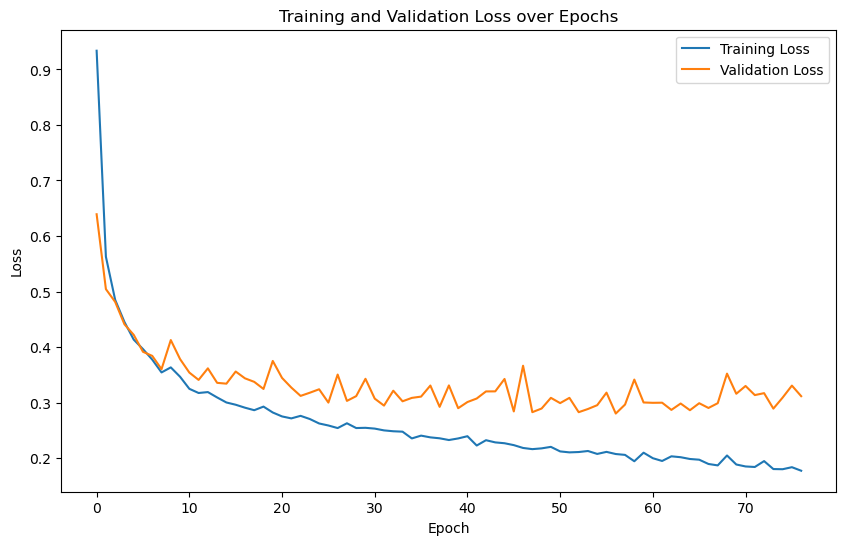

In [21]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_barlow_twins_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_barlow_twins_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [22]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.inner_model(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.inner_model(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [23]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.8807963097839281
Weighted F1 Score: 0.8802641243677056
Macro F1 Score: 0.8735945513919603
Random Guess Accuracy: 0.08554398369790313
                         precision    recall  f1-score   support

                B Cells       0.93      0.95      0.94       219
           CD4+ T Cells       0.90      0.95      0.92       392
           CD8+ T Cells       0.93      0.88      0.90       281
                 DCIS 1       0.82      0.77      0.79       293
                 DCIS 2       0.81      0.81      0.81       326
            Endothelial       0.96      0.96      0.96       154
              IRF7+ DCs       0.88      0.85      0.86        33
         Invasive Tumor       0.85      0.91      0.87       701
             LAMP3+ DCs       0.88      0.79      0.83        19
          Macrophages 1       0.93      0.93      0.93       425
          Macrophages 2       0.90      0.90      0.90       106
             Mast Cells       1.00      0.92      0.96   

In [24]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.inner_model(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_BT_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'BT_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'BT_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'BT_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'BT_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'BT_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [25]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "MERSCOPE_human_neocortex_barlow_twins_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['MERSCOPE_human_neocortex'],
    'method': [re.search(r'neocortex_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
0.934	0.639	57	0.280	0.874	0.880	0.881
